In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import cv2
from sklearn.utils import shuffle
import seaborn as sns

In [52]:
categories = ['train', 'test', 'val', 'auto_test'] # 전처리된 데이터셋을 훈련용, 평가용, 검증용으로 구분
path = 'C:/dataset'
data_dir = path+'/osteoarthritis_aug_class3/'
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # Mac OS
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [55]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn.utils import shuffle

# 이미지 전처리 함수들
def resize_image(img, size=(128, 128)):
    return cv2.resize(img, size)

def clahe_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def normalize_img(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

def denoise_img(img):
    return cv2.fastNlMeansDenoising(img, None, 30, 7, 21)

def adjust_gamma(image, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

def crop_knee(image, crop_height, crop_width):
    h, w = image.shape[:2]
    center = (h // 2, w // 2)
    cropped_img = image[
        center[0] - crop_height // 2 : center[0] + crop_height // 2,
        center[1] - crop_width // 2 : center[1] + crop_width // 2
    ]
    return cropped_img


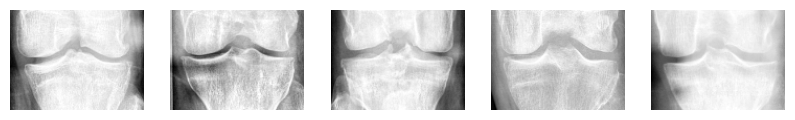

In [54]:
def load_data(data_dir):
    images = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = resize_image(img)
                img = crop_knee(img, 320, 400)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    return np.array(images)

def load_and_augment_data(data_dir, label):
    label_path = os.path.join(data_dir, 'train', str(label))

    images = []
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        if img_name.endswith('.png') and os.path.isfile(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = resize_image(img)
                img = crop_knee(img, 320, 400)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)

    
    return np.array(images)


# 데이터 로딩 및 시각화
category = 'train'
label = 2

if category == 'train' and label == 2:
    images = load_and_augment_data(data_dir, label)
else:
    label_path = os.path.join(data_dir, category, str(label))
    if os.path.isdir(label_path):
        images = load_data(label_path)
    else:
        images = np.array([])

if len(images) > 0:
    random_images = images[np.random.choice(images.shape[0], 5, replace=False)]

    plt.figure(figsize=(10, 5))
    for i, img in enumerate(random_images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()
else:
    print("이미지가 없습니다.")


In [42]:
# 각 카테고리와 라벨에 따라 이미지를 처리
all_data = {}
for category in categories:
    category_path = os.path.join(data_dir, category)
    all_data[category] = {}
    for label in range(3):
        if category == 'train' and label == 2:
            processed_img_list = load_and_augment_data(data_dir, label)
        else:
            label_path = os.path.join(category_path, str(label))
            if os.path.isdir(label_path):
                processed_img_list = load_data(label_path)
            else:
                processed_img_list = np.array([])
        all_data[category][label] = processed_img_list


In [43]:
# Function to sample 500 images from each label for training
def sample_images(data, num_samples=500):
    sampled_data = []
    sampled_labels = []
    for label, images in data.items():
        if len(images) >= num_samples:
            sampled_data.append(images[:num_samples])
            sampled_labels.append(np.full(num_samples, label))
        else:
            sampled_data.append(images)
            sampled_labels.append(np.full(len(images), label))
    sampled_data = np.concatenate(sampled_data, axis=0)
    sampled_labels = np.concatenate(sampled_labels, axis=0)
    return shuffle(sampled_data, sampled_labels)

In [44]:
# Sample 500 images
train_data_sampled, train_labels_sampled = sample_images(all_data['train'])
val_data_sampled, val_labels_sampled = sample_images(all_data['val'])
test_data_sampled, test_labels_sampled = sample_images(all_data['test'])

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

val_data_combined = []
val_labels_combined = []
test_data_combined = []
test_labels_combined = []

for dataset in ['val', 'test']:
    for label, images in all_data[dataset].items():
        if dataset == 'val':
            val_data_combined.append(images)
            val_labels_combined.append(np.full(images.shape[0], label))
        else:
            test_data_combined.append(images)
            test_labels_combined.append(np.full(images.shape[0], label))

val_data_combined = np.concatenate(val_data_combined, axis=0)
val_labels_combined = np.concatenate(val_labels_combined, axis=0)
test_data_combined = np.concatenate(test_data_combined, axis=0)
test_labels_combined = np.concatenate(test_labels_combined, axis=0)
# PyTorch 텐서로 변환
train_data_tensor = torch.tensor(train_data_sampled, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_sampled, dtype=torch.long)
val_data_tensor = torch.tensor(val_data_combined, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels_combined, dtype=torch.long)
test_data_tensor = torch.tensor(test_data_combined, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_combined, dtype=torch.long)

# PyTorch 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
train_data_tensor.shape,train_labels_tensor.shape ,test_data_tensor.shape, test_labels_tensor.shape

(torch.Size([1500, 96, 128]),
 torch.Size([1500]),
 torch.Size([1656, 96, 128]),
 torch.Size([1656]))

In [47]:
val_data_tensor.shape, test_data_tensor.shape, val_labels_tensor.shape, test_labels_tensor.shape

(torch.Size([826, 96, 128]),
 torch.Size([1656, 96, 128]),
 torch.Size([826]),
 torch.Size([1656]))

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import precision_score, recall_score, f1_score

num_classes = 3

def get_pretrained_model(model_name, num_classes):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'mobilenetv2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'vgg19':
        model = models.vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError('Unknown model name')
    
    return model

# 사전학습 모델 설정
criterion = nn.CrossEntropyLoss()
model_name = 'resnet'
model = get_pretrained_model(model_name, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Freeze initial layers
for param in model.parameters():
    param.requires_grad = False

if model_name == 'resnet':
    for param in model.fc.parameters():
        param.requires_grad = True
elif model_name == 'densenet':
    for param in model.classifier.parameters():
        param.requires_grad = True
elif model_name == 'vgg16':
    for param in model.classifier[6].parameters():
        param.requires_grad = True
elif model_name == 'vgg19':
    for param in model.classifier[6].parameters():
        param.requires_grad = True
elif model_name == 'mobilenetv2':
    for param in model.classifier[1].parameters():
        param.requires_grad = True


# optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=0.001)
optimizer = optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_predictions = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        if inputs.ndim == 3:
            inputs = inputs.unsqueeze(1)
        if inputs.shape[1] == 1:
            inputs = inputs.repeat(1, 3, 1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())
        
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
    train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_predictions = []
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            if images.ndim == 3:
                images = images.unsqueeze(1)
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_precision = precision_score(all_val_labels, all_val_predictions, average='macro')
    val_recall = recall_score(all_val_labels, all_val_predictions, average='macro')
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='macro')
    
    print(f'TEpoch {epoch + 1}, Train loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Train Precision: {train_precision:.2f}, Train Recall: {train_recall:.2f}, Train F1-Score: {train_f1:.2f}')
    print(f'VEpoch {epoch + 1}, Validation loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%, '
          f'Validation Precision: {val_precision:.2f}, Validation Recall: {val_recall:.2f}, Validation F1-Score: {val_f1:.2f}')
    print('학습 끝~')
    print('='*60)


c:\Users\igyuw\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\igyuw\anaconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TEpoch 1, Train loss: 0.927, Train Accuracy: 55.00%, Train Precision: 0.54, Train Recall: 0.55, Train F1-Score: 0.55
VEpoch 1, Validation loss: 0.906, Validation Accuracy: 43.34%, Validation Precision: 0.35, Validation Recall: 0.37, Validation F1-Score: 0.27
학습 끝~
TEpoch 2, Train loss: 0.719, Train Accuracy: 68.47%, Train Precision: 0.68, Train Recall: 0.68, Train F1-Score: 0.68
VEpoch 2, Validation loss: 0.820, Validation Accuracy: 56.54%, Validation Precision: 0.39, Validation Recall: 0.43, Validation F1-Score: 0.36
학습 끝~
TEpoch 3, Train loss: 0.632, Train Accuracy: 73.40%, Train Precision: 0.73, Train Recall: 0.73, Train F1-Score: 0.73
VEpoch 3, Validation loss: 0.800, Validation Accuracy: 61.02%, Validation Precision: 0.40, Validation Recall: 0.46, Validation F1-Score: 0.39
학습 끝~
TEpoch 4, Train loss: 0.600, Train Accuracy: 75.07%, Train Precision: 0.75, Train Recall: 0.75, Train F1-Score: 0.75
VEpoch 4, Validation loss: 0.861, Validation Accuracy: 56.17%, Validation Precision: 0.4

In [49]:
# Testing phase
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        # Ensure images have the correct shape (N, C, H, W) and convert grayscale to RGB
        if images.ndim == 3:
            images = images.unsqueeze(1)  # Add channel dimension if missing
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
test_precision = precision_score(all_labels, all_predictions, average='macro')
test_recall = recall_score(all_labels, all_predictions, average='macro')
test_f1 = f1_score(all_labels, all_predictions, average='macro')

print(f'Test Accuracy: {test_accuracy:.2f}%, Test Precision: {test_precision:.2f}, '
      f'Test Recall: {test_recall:.2f}, Test F1-Score: {test_f1:.2f}')


Test Accuracy: 59.66%, Test Precision: 0.43, Test Recall: 0.46, Test F1-Score: 0.41


Confusion Matrix:
[[853 496  33]
 [ 83 124  16]
 [  8  32  11]]


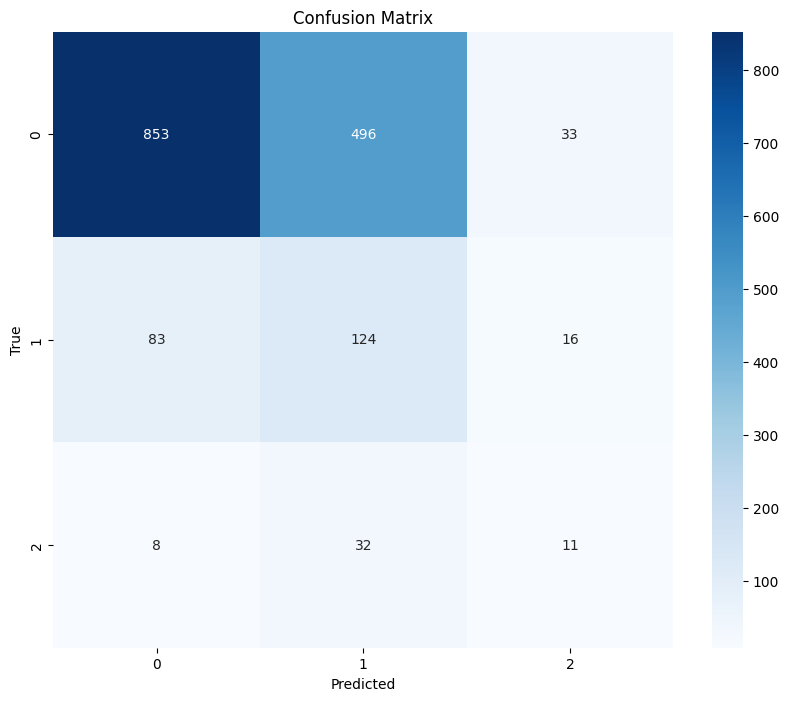

In [50]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# # 0 : 1382
# # 1 : 223
# # 2 : 51